In [203]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import math
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

In [204]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = "/content/drive/MyDrive/"
# parent directory
# parent_dir = Path.cwd().parent

# path to the dataset
# data_path = os.path.join(parent_dir ,'data','raw','weekly-train-1.csv')

# reading a CSV file into a DataFrame
df = pd.read_csv(drive_path+'weekly-train-1.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [205]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_COUPON,IS_DISPLAY,IS_FEATURE,IS_PROMO,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,True,False,True,False,False,False,False,False,False,False,False,False
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,True,False,True,False,False,False,False,False,False,False,False,False
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,False,False,False,False
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,False,False,False,False
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,True,False,False,False,False,False,False,False,False,False


In [206]:
# notice how 'tot_sales' minimum value is 0, which could be a problem for MAPE calculation
df.describe()

,PRODUCT_ID,TOTAL_SALES,PRICE
count,1.016000e+03,1016.000000,1016.000000
mean,1.945143e+11,10771.734175,6.068612
std,3.310960e+11,9334.724659,1.540878
min,3.450014e+09,0.000000,3.334068
25%,3.450015e+09,4485.396779,4.985093
50%,3.450015e+09,7533.615062,5.665874
75%,1.945143e+11,15534.721163,6.587589
max,7.677070e+11,45877.859803,10.475405


In [207]:
df.shape

(1016, 18)

In [208]:
# checking for missing values in the DataFrame
df.isnull().sum()

,0
PRODUCT_DESC,0
PRODUCT_ID,0
DATE,0
TOTAL_SALES,0
PRICE,0
IS_COUPON,0
IS_DISPLAY,0
IS_FEATURE,0
IS_PROMO,0
IS_INDEPENDENCE_DAY,0


In [209]:
# checking the data types of each column in the DataFrame
for col in df.columns:
    print(f"{col}: {df[col].dtype}")

PRODUCT_DESC: object
PRODUCT_ID: int64
DATE: object
TOTAL_SALES: float64
PRICE: float64
IS_COUPON: bool
IS_DISPLAY: bool
IS_FEATURE: bool
IS_PROMO: bool
IS_INDEPENDENCE_DAY: bool
IS_PRE_CHRISTMAS: bool
IS_SUPER_BOWL_SUNDAY: bool
IS_PRE_THANKSGIVING: bool
IS_EASTER_SUNDAY: bool
IS_LABOR_DAY: bool
IS_MEMORIAL_DAY: bool
IS_THANKSGIVING: bool
IS_CHRISTMAS_DAY: bool


In [210]:
# converting the 'DATE' column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])
print(df['DATE'].dtype.name)

datetime64[ns]


## Feature Engineering
Re-arranging some features in order to be able to extract useful information

### Holiday Features
Those are boolean features that can be left as they are, since XGBoost automatically converts them into integers. Probably is better to keep all of them, not to lose any interesting information.

In [211]:
# summarizing holiday columns in one column
#holiday_cols  = ['IS_INDEPENDENCE_DAY', 'IS_LABOR_DAY', 'IS_MEMORIAL_DAY',
#                'IS_THANKSGIVING', 'IS_EASTER_SUNDAY',
#                 'IS_CHRISTMAS_DAY', 'IS_PRE_CHRISTMAS', 'IS_SUPER_BOWL_SUNDAY', 'IS_PRE_THANKSGIVING']

#df["IS_HOLIDAY_WEEK"] = df[holiday_cols].sum(axis=1)
#df.drop(columns=holiday_cols, inplace=True)
#df.head()

### Promotion Features
Boolean features: the most important one is IS_PROMO, which indicates if there was any promotion.
IS_COUPON, IS_DISPLAY, IS_FEATURE are support variables that might increase the TOT_SALES.

Promotion features can be summarized in a PROMO_LEVEL feature, that indicates how much promoted the product in the week was. This new feature can be realized in different ways: by a naive summation of the attributes or by a weighted sum.

In [212]:
#converting boolean values in dummy variables for promo features
df['IS_PROMO']=df['IS_PROMO'].astype(int)
df['IS_COUPON']=df['IS_COUPON'].astype(int)
df['IS_DISPLAY']=df['IS_DISPLAY'].astype(int)
df['IS_FEATURE']=df['IS_FEATURE'].astype(int)

In [213]:
# creating a feature that indicates promotional level
# NOTICE: this can be improved, eventually considering a weighted sum based on promo supports
df['PROMO_LEVEL'] = df['IS_PROMO'] + df['IS_COUPON'] + df['IS_DISPLAY'] + df['IS_FEATURE']
df.drop(columns=['IS_PROMO', 'IS_COUPON', 'IS_DISPLAY', 'IS_FEATURE'], inplace=True)
df.head()

,PRODUCT_DESC,PRODUCT_ID,DATE,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,PROMO_LEVEL
0,Yogurt_Greek,3450014449,2020-12-28,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,2
1,Yogurt_Greek,3450014449,2021-01-04,20366.054602,5.666967,False,False,False,False,False,False,False,False,False,2
2,Yogurt_Greek,3450014449,2021-01-11,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,0
3,Yogurt_Greek,3450014449,2021-01-18,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,0
4,Yogurt_Greek,3450014449,2021-01-25,18867.597360,5.040478,False,False,False,False,False,False,False,False,False,1


### Time Features
We need to extract information from the 'DATE' feature. Useful information might be:
- YEAR
- MONTH
- WEEK_NUM
- SEASON

#### Cyclical Encoding for Time Variables

##### 1. The Challenge: Linear Models vs. Cyclical Time
Standard machine learning models perceive numerical features linearly.
* The Issue: To a model, Month 12 (December) and Month 1 (January) are "far apart" (distance = 11).
* The Reality: In the real world, December and January are adjacent (distance = 1). The same logic applies to Weeks (Week 52 $\to$ Week 1) and Hours (23:00 $\to$ 00:00).

If we feed raw numbers (for example, 1-12) into the model, it fails to capture the continuity of the cycle, creating a "break" in the data at the end of the year.

##### 2. The Solution: Mapping to a Unit Circle
To solve this, we map our time features onto a 2D Unit Circle. Instead of a single scalar value, we represent every time point as a coordinate pair $(x, y)$ on a circle. This preserves the relative distance between points (for example, the distance between Dec 31 and Jan 1 becomes very small).

##### 3. The Transformation Formulas
We create two new features for every cyclical variable using Sine and Cosine transformations.

For a time variable $t$ with a maximum cycle length $T_{max}$ (for example, $T_{max}=12$ for months, $T_{max}=53$ for weeks):

$$
x_{sin} = \sin\left(\frac{2 \pi \times t}{T_{max}}\right)
$$

$$
x_{cos} = \cos\left(\frac{2 \pi \times t}{T_{max}}\right)
$$

We need both dimensions to define a unique point on the circle.
* If we only used Sine, two different points in the cycle (for example, rising in Spring vs. falling in Autumn) could have the exact same value.
* Adding Cosine breaks this symmetry, ensuring every point in time has a unique $(x, y)$ coordinate.

In [214]:
# extracting time information from the 'DATE' column
# TO CHECK: is raw MONTH a good feature? sin and cos month?
df['MONTH'] = df['DATE'].dt.month

# TO CHECK: is WEEK_IN_MONTH a good feature? it seems a bit weak, maybe WEEM_IN_YEAR is better?
df['WEEK_NUMBER'] = df['DATE'].dt.isocalendar().week

# adding YEAR as a feature, to capture potential trends over time
df['YEAR'] = df['DATE'].dt.year

# adding SEASON as a feature, to capture potential seasonal patterns
df['SEASON'] = df['MONTH'].apply(lambda x: (x%12 + 3) // 3)

df.drop(columns=['DATE'], inplace=True)
df.head()

,PRODUCT_DESC,PRODUCT_ID,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,IS_CHRISTMAS_DAY,PROMO_LEVEL,MONTH,WEEK_NUMBER,YEAR,SEASON
0,Yogurt_Greek,3450014449,20461.337740,5.667959,False,False,False,False,False,False,False,False,False,2,12,53,2020,1
1,Yogurt_Greek,3450014449,20366.054602,5.666967,False,False,False,False,False,False,False,False,False,2,1,1,2021,1
2,Yogurt_Greek,3450014449,18072.334581,5.667983,False,False,False,False,False,False,False,False,False,0,1,2,2021,1
3,Yogurt_Greek,3450014449,18119.333530,5.667809,False,False,False,False,False,False,False,False,False,0,1,3,2021,1
4,Yogurt_Greek,3450014449,18867.597360,5.040478,False,False,False,False,False,False,False,False,False,1,1,4,2021,1


In [215]:
weeks_in_year = df["WEEK_NUMBER"].max()

df["WEEK_SIN"] = np.sin(2 * np.pi * df["WEEK_NUMBER"] / weeks_in_year)
df["WEEK_COS"] = np.cos(2 * np.pi * df["WEEK_NUMBER"] / weeks_in_year)

In [216]:
df["MONTH_SIN"] = np.sin(2 * np.pi * df["MONTH"] / 12)
df["MONTH_COS"] = np.cos(2 * np.pi * df["MONTH"] / 12)

In [217]:
df["SEASON_SIN"] = np.sin(2 * np.pi * df["SEASON"] / 4)
df["SEASON_COS"] = np.cos(2 * np.pi * df["SEASON"] / 4)

In [218]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,...,MONTH,WEEK_NUMBER,YEAR,SEASON,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS
0,Yogurt_Greek,3450014449,20461.337740,5.667959,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.000000,1.0,6.123234e-17
1,Yogurt_Greek,3450014449,20366.054602,5.666967,False,False,False,False,False,False,...,1,1,2021,1,0.118273,0.992981,5.000000e-01,0.866025,1.0,6.123234e-17
2,Yogurt_Greek,3450014449,18072.334581,5.667983,False,False,False,False,False,False,...,1,2,2021,1,0.234886,0.972023,5.000000e-01,0.866025,1.0,6.123234e-17
3,Yogurt_Greek,3450014449,18119.333530,5.667809,False,False,False,False,False,False,...,1,3,2021,1,0.348202,0.93742,5.000000e-01,0.866025,1.0,6.123234e-17
4,Yogurt_Greek,3450014449,18867.597360,5.040478,False,False,False,False,False,False,...,1,4,2021,1,0.456629,0.889657,5.000000e-01,0.866025,1.0,6.123234e-17


### ID Features
PRODUCT_DESC is not useful for the purpose of predicting sales, as it's simply a human-readable label for the product. It will be later dropped.
 We can keep PRODUCT_ID, but we must consider it as a **categorical** variable, NOT AS A NUMBER! Otherwise the model might assume there's some order between IDs, which are actually simple labels. Also, 'category' type allows to save memory compared to int64 variable.

In [219]:
df['PRODUCT_DESC'].unique()

array(['Yogurt_Greek', 'Yogurt_Mini_Light', 'Yogurt_Classic',
       'Yogurt_Mini_Classic', 'Yogurt_Mini_Greek', 'Yogurt_Giant_Classic',
       'Gold_Yogurt_Mini_Classic', 'Gold_Yogurt_Mini_Greek'], dtype=object)

In [220]:
# turning product_id into a categorical variable
df['PRODUCT_ID'] = df['PRODUCT_ID'].astype('category')
df.head()

,PRODUCT_DESC,PRODUCT_ID,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,...,MONTH,WEEK_NUMBER,YEAR,SEASON,WEEK_SIN,WEEK_COS,MONTH_SIN,MONTH_COS,SEASON_SIN,SEASON_COS
0,Yogurt_Greek,3450014449,20461.337740,5.667959,False,False,False,False,False,False,...,12,53,2020,1,-0.0,1.0,-2.449294e-16,1.000000,1.0,6.123234e-17
1,Yogurt_Greek,3450014449,20366.054602,5.666967,False,False,False,False,False,False,...,1,1,2021,1,0.118273,0.992981,5.000000e-01,0.866025,1.0,6.123234e-17
2,Yogurt_Greek,3450014449,18072.334581,5.667983,False,False,False,False,False,False,...,1,2,2021,1,0.234886,0.972023,5.000000e-01,0.866025,1.0,6.123234e-17
3,Yogurt_Greek,3450014449,18119.333530,5.667809,False,False,False,False,False,False,...,1,3,2021,1,0.348202,0.93742,5.000000e-01,0.866025,1.0,6.123234e-17
4,Yogurt_Greek,3450014449,18867.597360,5.040478,False,False,False,False,False,False,...,1,4,2021,1,0.456629,0.889657,5.000000e-01,0.866025,1.0,6.123234e-17


### Lag Features and Rolling Windows
When performing a regression task on time series, like this one, is also important to consider **Lag Features** and **Rolling Windows**. These artificial features give our model a sort of context, that allows it to keep track of past trends and events.

In [221]:
# adding lag features for the target variable 'TOTAL_SALES'
# lag 1, lag 4, lag 52 (1 year)
df['LAG_1'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].shift(1)
df['LAG_4'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].shift(4)
df['LAG_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].shift(52)

# rolling mean and std for the target variable 'TOTAL_SALES'
# roll 4, roll 8, roll 52 (1 year)
# grouping by 'PRODUCT_ID' and transforming via lamba functions to calculate rolling mean and std, shifting by 1 to avoid data leakage
df['ROLL_MEAN_4'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=4).mean())
df['ROLL_STD_4'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=4).std())

df['ROLL_MEAN_8'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=8).mean())
df['ROLL_STD_8'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=8).std())

df['ROLL_MEAN_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=52).mean())
df['ROLL_STD_52'] = df.groupby('PRODUCT_ID', observed=False)['TOTAL_SALES'].transform(lambda x: x.shift(1).rolling(window=52).std())

In [222]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,...,SEASON_COS,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
0,Yogurt_Greek,3450014449,20461.337740,5.667959,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yogurt_Greek,3450014449,20366.054602,5.666967,False,False,False,False,False,False,...,6.123234e-17,20461.337740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Yogurt_Greek,3450014449,18072.334581,5.667983,False,False,False,False,False,False,...,6.123234e-17,20366.054602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Yogurt_Greek,3450014449,18119.333530,5.667809,False,False,False,False,False,False,...,6.123234e-17,18072.334581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Yogurt_Greek,3450014449,18867.597360,5.040478,False,False,False,False,False,False,...,6.123234e-17,18119.333530,20461.33774,NaN,19254.765113,1338.921043,NaN,NaN,NaN,NaN


## Data Exploration
Performing some Data Exploration in order to have a visualization of our data. This can help us understand trends and distribution of sales over weeks, months and seasons.

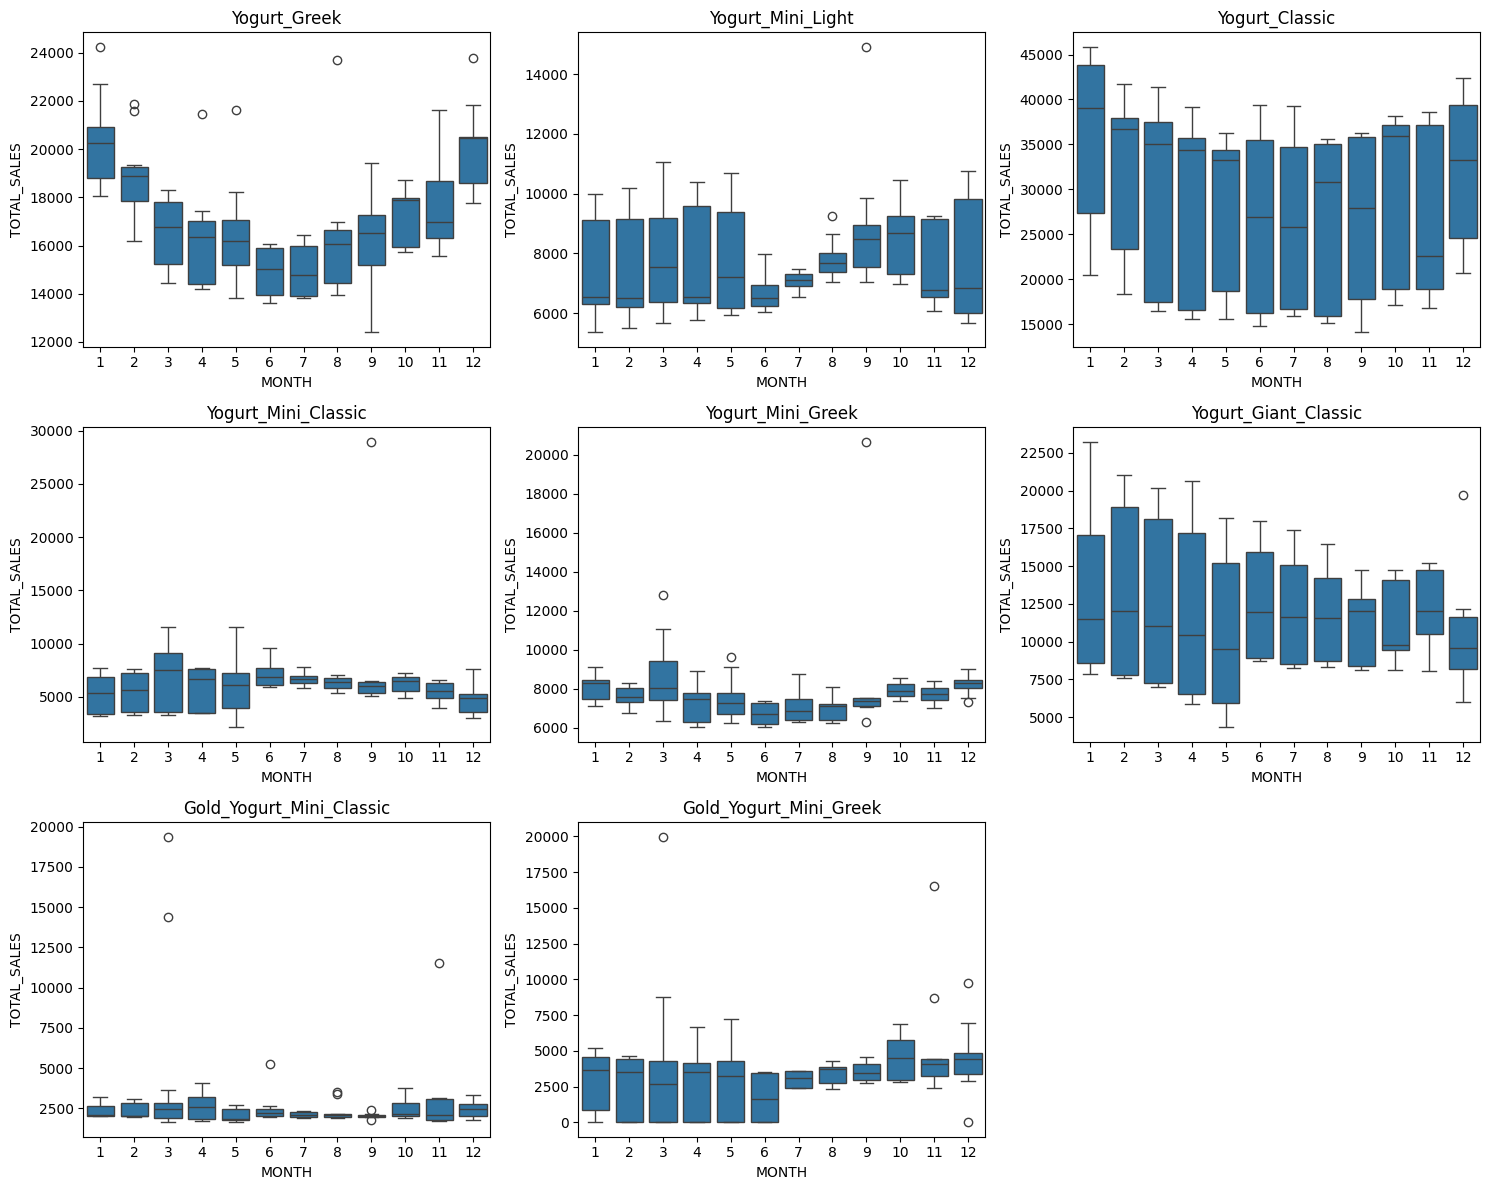

In [223]:
# boxplot of TOTAL_SALES by MONTH for each PRODUCT_DESC
products = df['PRODUCT_DESC'].unique()
n_products = len(products)

n_cols = 3
n_rows = math.ceil(n_products / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.boxplot(
        x='MONTH',
        y='TOTAL_SALES',
        data=df[df['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(f'{product}')
    ax.set_xlabel('MONTH')
    ax.set_ylabel('TOTAL_SALES')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

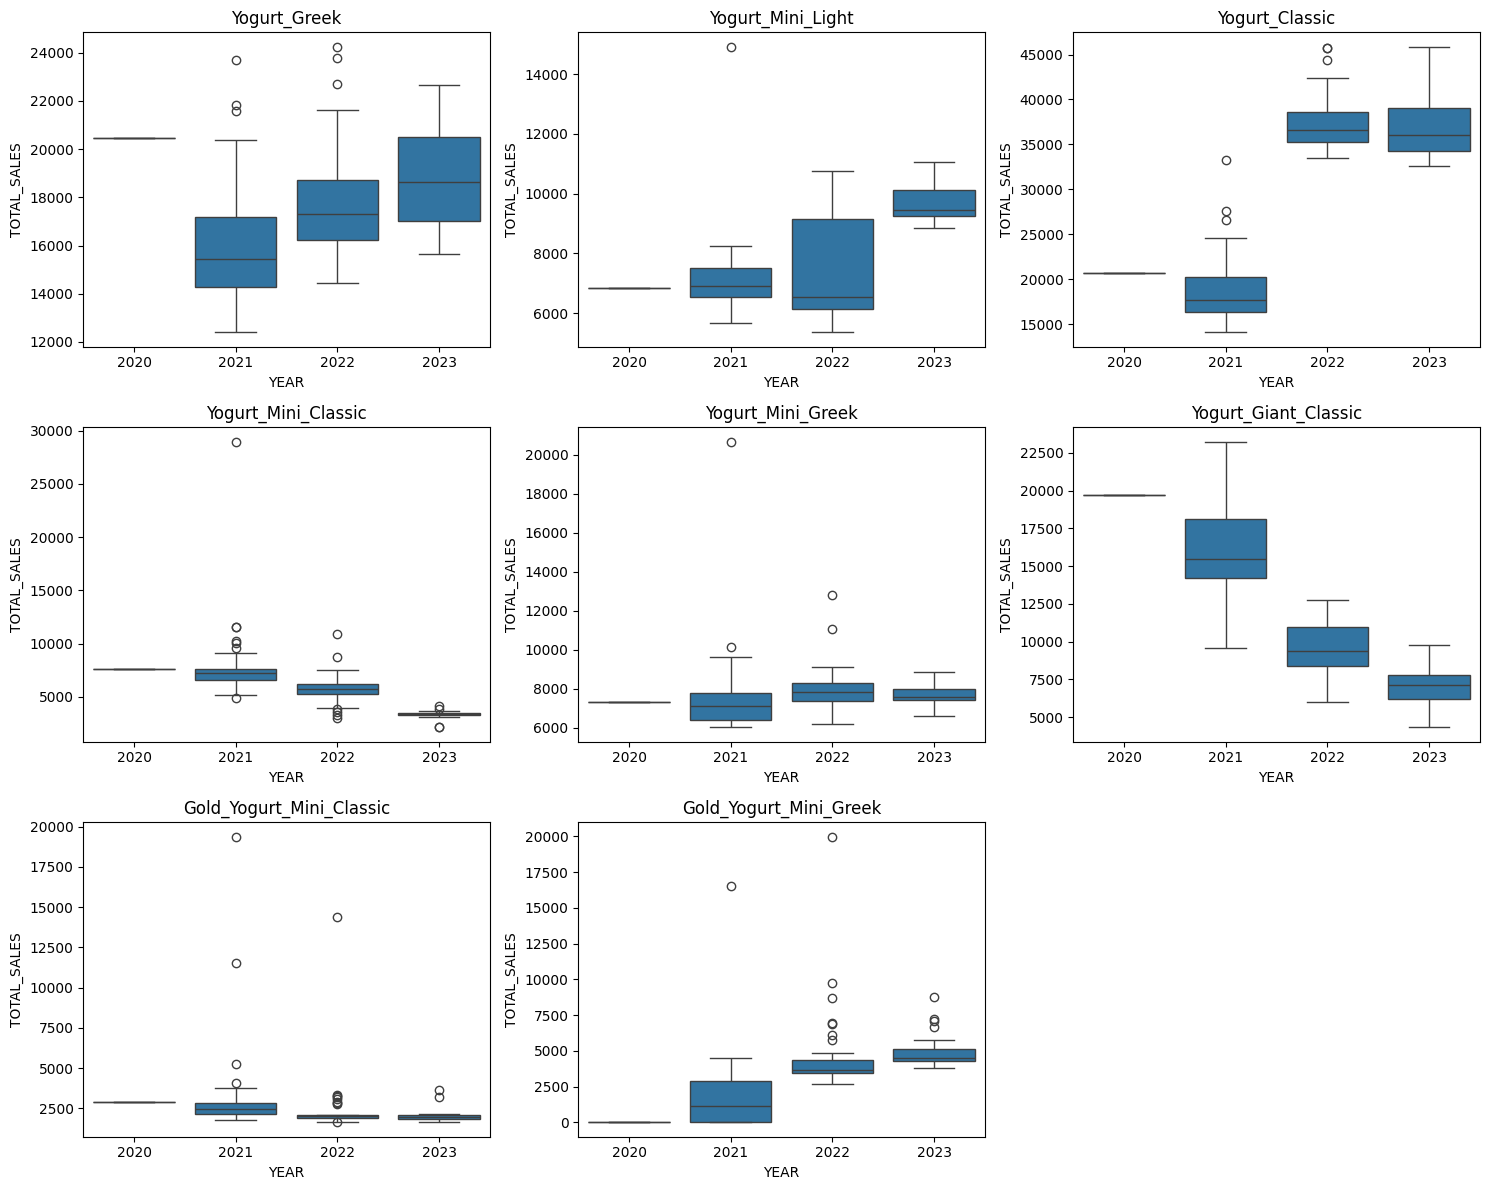

In [224]:
# boxplot of TOTAL_SALES by YEAR for each PRODUCT_DESC
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.boxplot(
        x='YEAR',
        y='TOTAL_SALES',
        data=df[df['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(product)
    ax.set_xlabel('YEAR')
    ax.set_ylabel('TOTAL_SALES')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

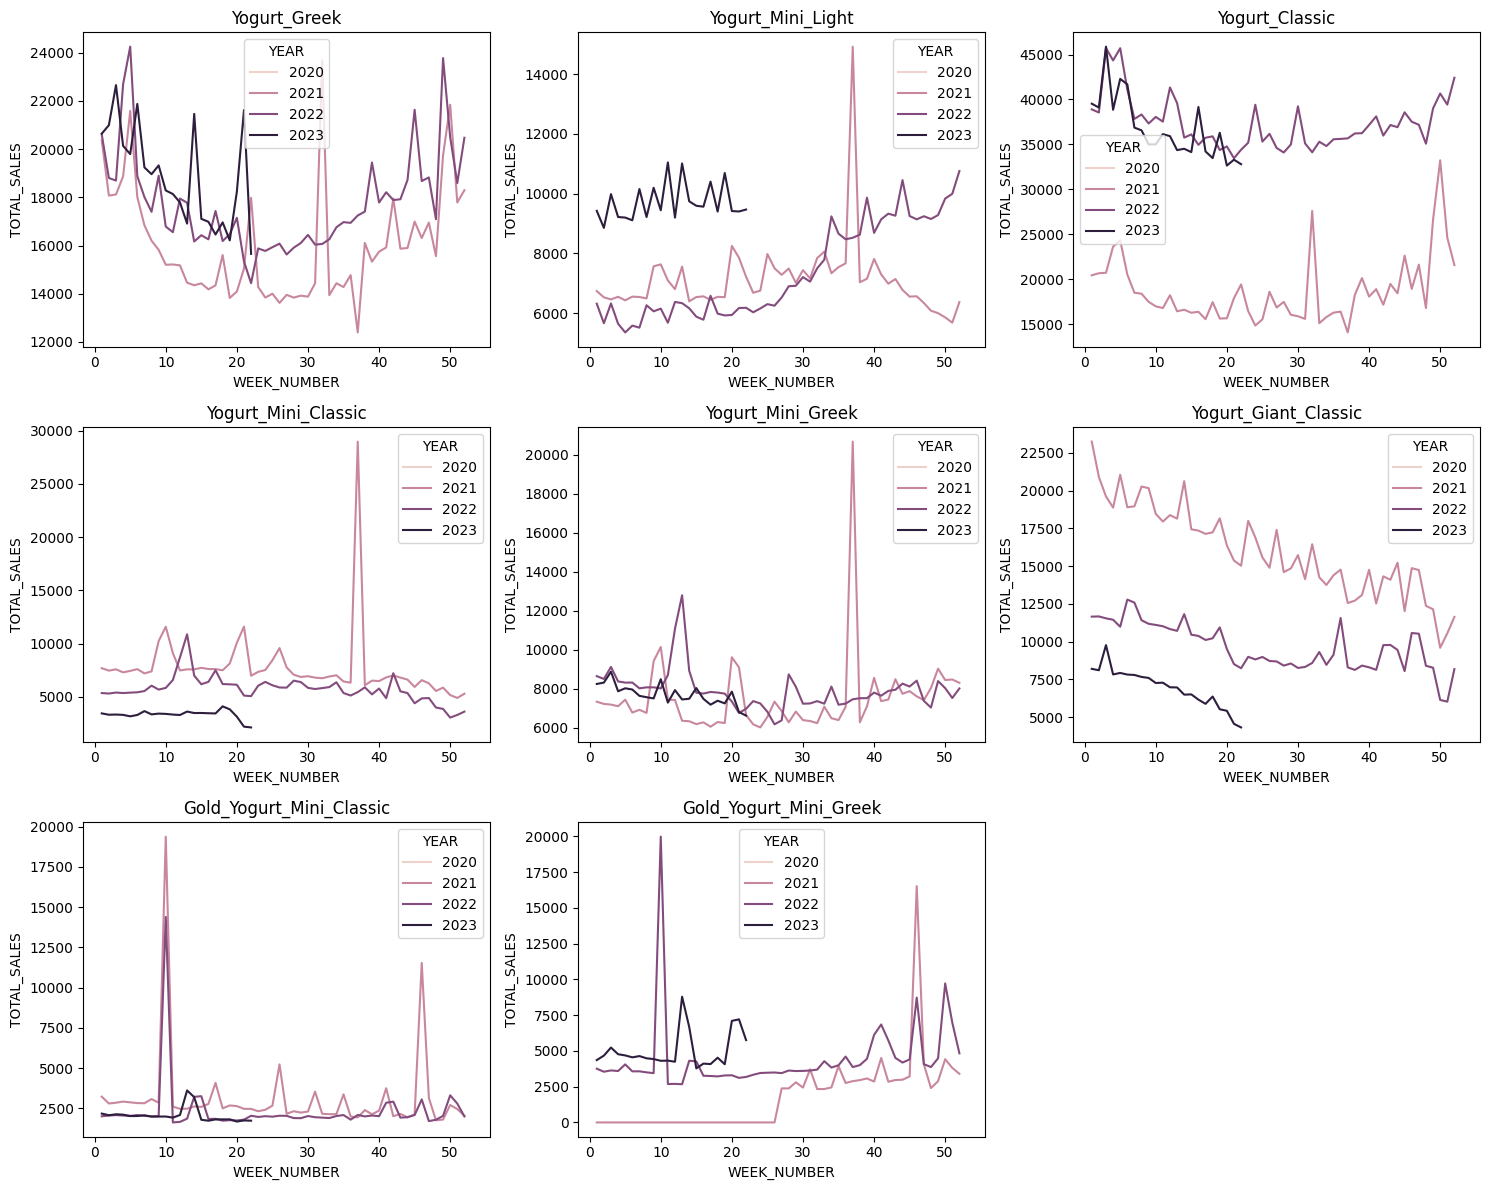

In [225]:
# lineplot of TOTAL_SALES over time for each PRODUCT_DESC
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()

for ax, product in zip(axes, products):
    sns.lineplot(
        x='WEEK_NUMBER',
        y='TOTAL_SALES',
         hue='YEAR',
         data=df[df['PRODUCT_DESC'] == product],
        ax=ax
    )
    ax.set_title(f'{product}')
    ax.set_xlabel('WEEK_NUMBER')
    ax.set_ylabel('TOTAL_SALES')
    ax.legend(title='YEAR')

# to delete empty subplots if the number of products is not a multiple of n_cols
for i in range(len(products), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

After plotting, since we have the transformed version of WEEK_NUMBER, MONTH, and SEASON, they are redundunt and we eliminate them.

In [ ]:
df.drop(columns=['WEEK_NUMBER', 'MONTH', 'SEASON'], inplace=True, axis = 1)

In [226]:
df.head()

,PRODUCT_DESC,PRODUCT_ID,TOTAL_SALES,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,...,SEASON_COS,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
0,Yogurt_Greek,3450014449,20461.337740,5.667959,False,False,False,False,False,False,...,6.123234e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yogurt_Greek,3450014449,20366.054602,5.666967,False,False,False,False,False,False,...,6.123234e-17,20461.337740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Yogurt_Greek,3450014449,18072.334581,5.667983,False,False,False,False,False,False,...,6.123234e-17,20366.054602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Yogurt_Greek,3450014449,18119.333530,5.667809,False,False,False,False,False,False,...,6.123234e-17,18072.334581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Yogurt_Greek,3450014449,18867.597360,5.040478,False,False,False,False,False,False,...,6.123234e-17,18119.333530,20461.33774,NaN,19254.765113,1338.921043,NaN,NaN,NaN,NaN


## Preparing dataset for training
Splitting the dataset into training and test dataset. Standardizing numerical feature in order to enable better performances of our regression model.

In [ ]:
X = df.drop(columns=['TOTAL_SALES', 'PRODUCT_DESC']) # dropping non-numeric and target columns
y = df['TOTAL_SALES']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((812, 25), (204, 25), (812,), (204,))

In [ ]:
X_train

,PRODUCT_ID,PRICE,IS_INDEPENDENCE_DAY,IS_PRE_CHRISTMAS,IS_SUPER_BOWL_SUNDAY,IS_PRE_THANKSGIVING,IS_EASTER_SUNDAY,IS_LABOR_DAY,IS_MEMORIAL_DAY,IS_THANKSGIVING,...,SEASON,LAG_1,LAG_4,LAG_52,ROLL_MEAN_4,ROLL_STD_4,ROLL_MEAN_8,ROLL_STD_8,ROLL_MEAN_52,ROLL_STD_52
0,3450014449,5.667959,False,False,False,False,False,False,False,False,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3450014449,5.666967,False,False,False,False,False,False,False,False,...,1,20461.337740,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3450014449,5.667983,False,False,False,False,False,False,False,False,...,1,20366.054602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3450014449,5.667809,False,False,False,False,False,False,False,False,...,1,18072.334581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3450014449,5.040478,False,False,False,False,False,False,False,False,...,1,18119.333530,20461.337740,NaN,19254.765113,1338.921043,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,767707002231,7.904661,False,False,False,False,False,False,False,False,...,4,1953.567324,3752.180376,NaN,2468.811338,859.730071,2338.666456,596.312336,NaN,NaN
808,767707002231,3.598257,False,False,False,False,False,False,False,True,...,4,2125.079394,2014.439235,NaN,2062.036093,94.266547,2361.707161,582.133605,NaN,NaN
809,767707002231,7.092450,False,False,False,False,False,False,False,True,...,4,11536.792177,2155.058418,NaN,4442.624328,4730.278165,3504.227817,3297.407960,NaN,NaN
810,767707002231,7.914459,False,True,False,False,False,False,False,False,...,4,3151.508607,1953.567324,NaN,4691.736875,4593.923099,3631.361770,3256.401923,NaN,NaN


In [ ]:
num_cols = ['PRICE']

#scaler = StandardScaler()
#X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
#X_test[num_cols] = scaler.transform(X_test[num_cols])

## Creating the Regression Model
We're gonna use XGBoost for this regression task.

In [ ]:
# creating model
base_est = xgb.XGBRegressor(tree_method='hist', random_state=42)


param_grid = {
    "n_estimators": [300, 500],
    "max_depth": [4, 6],
    "learning_rate": [0.03, 0.05],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1, 5]
}


'''
param_grid = {
    "n_estimators": [300, 500, 700],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [ 2,3,4],
    "min_child_weight": [1, 3, 5],
    "subsample": [ 0.8, 1.0],
    "colsample_bytree": [ 0.8, 1.0],
    "gamma": [0, 0.3, 0.5],
    "reg_alpha": [0, 0.5, 1],
    "reg_lambda": [1, 1.5, 2]
}
'''

gscv = GridSearchCV(estimator=base_est,
                    param_grid=param_grid,
                    scoring='neg_mean_squared_error',
                    cv=5, # 5-fold cross-validation
                    n_jobs=-1, # using all available cores
                    verbose=2)

gscv.fit(X_train, y_train)

xbm, xbm_params = gscv.best_estimator_, gscv.best_params_

print("Best parameters found: ", xbm_params)
print("Best score: ", -gscv.best_score_)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best score:  8757525.925484275


## Note:
- Should I convert BOOLEAN COLUMNS to int?
- Check what GPT is saying about the project. Why is RMSE so high rn?
- Remember to use MAPE as scoring!!